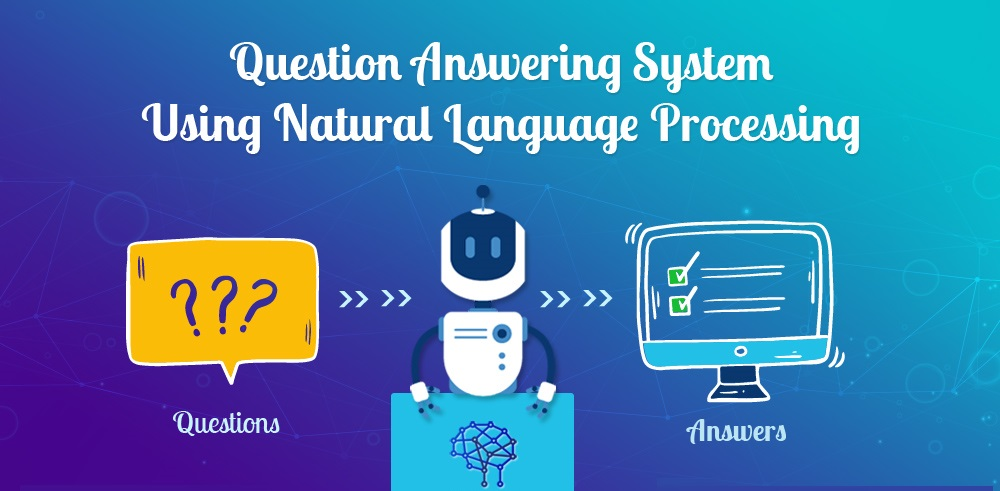

#Introduction
Question Answering On Custom Data
Question answering (QA) is a fundamental task in natural language processing (NLP) that involves developing models and techniques to automatically extract answers from a given set of textual documents or passages. With the advent of large language models (LLMs) like GPT-3, GPT-4, and others, the field of QA has seen significant advancements in its capabilities, especially when it comes to answering questions in a wide range of domains.

One of the most exciting developments in QA is the ability to create custom QA systems tailored to specific domains or knowledge bases. This customization allows organizations and individuals to build QA models that can provide precise and contextually relevant answers within a specific area of expertise. This approach is particularly valuable for applications such as customer support, legal research, medical diagnosis, and many others.

In this context, Natural Language Processing (NLP) plays a crucial role. NLP is a subfield of AI that focuses on enabling machines to understand, interpret, and generate human language text. When combined with LLMs, NLP techniques empower QA systems to process and comprehend textual data, extract relevant information, and generate coherent answers to user queries.

In [ ]:
#START

#Import Libraries

In [ ]:
!pip install -q openai
!pip install -q langchain
!pip install -q pinecone-client
!pip install -q python-dotenv
!pip install -q tiktoken
!pip install -q pypdf
!pip install -q docx2txt
!pip install -q wikipedia
!pip install -q chromadb

import os
import time
import pinecone
import tiktoken
from langchain.vectorstores import Pinecone
from langchain.vectorstores import Chroma
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.chains import RetrievalQA
from langchain.chains import ConversationalRetrievalChain
from langchain.chat_models import ChatOpenAI
from dotenv import load_dotenv, find_dotenv
from langchain.document_loaders import WikipediaLoader
from langchain.chains import RetrievalQA
from langchain.chains import ConversationalRetrievalChain

/usr/local/lib/python3.10/dist-packages/pinecone/index.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


#LangChain
LangChain is an open-source framework for developing applications powered by large language models (LLMs). It is written in Python and JavaScript and provides a number of features that make it easy to build and deploy applications that use LLMs, such as:

A modular architecture that allows you to easily combine different components to create your own custom applications.
A rich set of APIs that make it easy to interact with LLMs.
A built-in debugger that helps you troubleshoot your applications.
A documentation that provides detailed instructions on how to use the framework.

<b>LangChain can be used to build a wide variety of applications, including:</b>

* Chatbots

* Question-answering systems

* Text summarization systems

* Code generation systems

* Natural language generation systems

* Text analysis systems

LangChain is a powerful tool that can be used to build sophisticated applications that use LLMs. If you are interested in building applications that use LLMs, then LangChain is a good place to start.

<b>Here are some specific examples of what LangChain can be used for:</b>

* Building a chatbot that can have natural conversations with users.

* Developing a question-answering system that can answer user questions in an informative way, even if they are open-ended or challenging.

* Creating a text summarization system that can automatically generate summaries of long documents.

* Generating code from natural language descriptions.

* Analyzing text for sentiment, intent, or other features.

LangChain is still under development, but it is a promising framework that has the potential to make it easier to build and deploy applications that use LLMs.

In [ ]:
!pip show langchain

Name: langchain
Version: 0.0.284
Summary: Building applications with LLMs through composability
Home-page: https://github.com/langchain-ai/langchain
Author: 
Author-email: 
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: aiohttp, async-timeout, dataclasses-json, langsmith, numexpr, numpy, pydantic, PyYAML, requests, SQLAlchemy, tenacity
Required-by: 


#Read Data From Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Data Location
%cd drive/MyDrive/MachineLearningProjects/NaturalLanguageProcessing/QuestionAnsweringCustomData

/content/drive/MyDrive/MachineLearningProjects/NLP/QuestionAnsweringCustomData


#Load ENV Data

https://platform.openai.com/account/api-keys

https://www.pinecone.io

### sample

###### OPENAI_API_KEY   = ""

###### PINECONE_API_KEY = ""

###### PINECONE_ENV     = ""

In [ ]:
load_dotenv(find_dotenv(), override=True)

True

#Load Custom Data
loading PDF, DOCX,TXT files Also WikiPedia Page as LangChain Documents


In [ ]:
# Loading PDF, DOCX and TXT files as LangChain Documents
def LoadDocument(file):
    name, extension = os.path.splitext(file)
    if extension == '.pdf':
        from langchain.document_loaders import PyPDFLoader
        print(f'Loading {file}')
        loader = PyPDFLoader(file)
    elif extension == '.docx':
        from langchain.document_loaders import Docx2txtLoader
        print(f'Loading {file}')
        loader = Docx2txtLoader(file)
    elif extension == '.txt':
        from langchain.document_loaders import TextLoader
        loader = TextLoader(file)
    else:
        print('Document format is not supported!')
        return None

    data = loader.load()
    return data


# Loading Wikipedia Page as LangChain Documents
def LoadWikipediaData(query, lang='en', load_max_docs=2):
    loader = WikipediaLoader(query=query, lang=lang, load_max_docs=load_max_docs)
    data = loader.load()
    return data

#Chunking Data
chunking refers to the process of extracting meaningful groups of words (chunks) from a sentence or text.

Chunking is typically used as a pre-processing step for tasks like information extraction, named entity recognition, and syntactic parsing.

Chunking helps simplify the structure of a sentence, making it easier for subsequent NLP tasks to analyze and understand the text.

In [ ]:
def ChunkData(data, chunk_size=256):
    from langchain.text_splitter import RecursiveCharacterTextSplitter
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=0)
    chunks = text_splitter.split_documents(data)
    return chunks

#Embedding and Uploading to a Vector Database (Pinecone , Chroma)

Word embedding in natural language processing (NLP) is a technique used to represent words as continuous, dense vectors in a multi-dimensional space,
where each word is mapped to a point in this space.

These word vectors capture semantic relationships between words,making it possible for machines to understand and work with textual data more effectively.

Word embeddings are a fundamental component of many NLP tasks, including text classification, sentiment analysis, machine translation, and information retrieval.

They enable NLP models to understand the meaning of words and relationships between words, making it easier to work with natural language data in a computational context.

In [ ]:
# create embeddings using OpenAIEmbeddings() and save them in Pinecone vector store
def PineconeEmbeddings(index_name,chunks):
    embeddings = OpenAIEmbeddings()
    pinecone.init(api_key=os.environ.get('PINECONE_API_KEY'), environment=os.environ.get('PINECONE_ENV'))

    if index_name in pinecone.list_indexes():
        print(f'Index {index_name} already exists. Loading embeddings ... ', end='')
        vector_store = Pinecone.from_existing_index(index_name, embeddings)
        print('Ok')
    else:
        print(f'Creating index {index_name} and embeddings... ', end='')
        pinecone.create_index(index_name, dimension=1536, metric='cosine')
        vector_store = Pinecone.from_documents(chunks, embeddings, index_name=index_name)
        print('Ok')

    return vector_store

In [ ]:
# create embeddings using OpenAIEmbeddings() and save them in Chroma vector store
def ChromaEmbeddings(chunks):
    print('embeddings... ')
    embeddings = OpenAIEmbeddings()
    vector_store = Chroma.from_documents(chunks, embeddings)
    print('OK')
    return vector_store

In [ ]:
#Print Embedding Cost
def PrintEmbeddingCost(texts):
    enc = tiktoken.encoding_for_model('text-embedding-ada-002')
    total_tokens = sum([len(enc.encode(page.page_content)) for page in texts])
    print(f'Total Tokens: {total_tokens}')
    print(f'Embedding Cost in USD: {total_tokens / 1000 * 0.0004:.6f}')

In [ ]:
#Pinecone Free tier only support one index and we need to freq delete index
def DeletePineconeIndex(index_name='all'):
    pinecone.init(api_key=os.environ.get('PINECONE_API_KEY'), environment=os.environ.get('PINECONE_ENV'))
    if index_name == 'all':
        indexes = pinecone.list_indexes()
        print('Deleting all indexes ... ')
        for index in indexes:
            pinecone.delete_index(index)
        print('Ok')
    else:
        print(f'Deleting index {index_name} ...', end='')
        pinecone.delete_index(index_name)
        print('Ok')


In [ ]:
#Question Answering Functions
def QuestionAnswering(vector_store, question):
    llm = ChatOpenAI(model='gpt-3.5-turbo', temperature=1)
    retriever = vector_store.as_retriever(search_type='similarity', search_kwargs={'k': 3})
    chain = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=retriever)
    answer = chain.run(question)
    return answer

def QuestionAnsweringWithMemory(vector_store, question, chat_history):
    llm = ChatOpenAI(temperature=1)
    retriever = vector_store.as_retriever(search_type='similarity', search_kwargs={'k': 3})
    crc = ConversationalRetrievalChain.from_llm(llm, retriever)
    result = crc({'question': question, 'chat_history': chat_history})
    chat_history.append((question, result['answer']))
    return result, chat_history

# Question Answering On Custom Data

In [ ]:
#Load Data From Wikipedia
data = LoadWikipediaData('GPT-4')
print(data[0].page_content)

Generative Pre-trained Transformer 4 (GPT-4) is a multimodal large language model created by OpenAI, and the fourth in its series of GPT foundation models. It was initially released on March 14, 2023, and has been made publicly available via the paid chatbot product ChatGPT Plus, and via OpenAI's API.  As a transformer-based model, GPT-4 uses a paradigm where pre-training using both public data and "data licensed from third-party providers" is used to predict the next token. After this step, the model was then fine-tuned with reinforcement learning feedback from humans and AI for human alignment and policy compliance.: 2 Observers reported that the iteration of ChatGPT using GPT-4 was an improvement on the previous iteration based on GPT-3.5, with the caveat that GPT-4 retains some of the problems with earlier revisions. GPT-4 is also capable of taking images as input, though this feature has not been made available since launch. OpenAI has declined to reveal various technical details 

In [ ]:
# Load Data From Document
data = LoadDocument('data/data3.pdf')

Loading data/data3.pdf


In [ ]:
# Check Data
print(data[4].metadata)
print(f'You have {len(data)} pages in your data')
print(f'There are {len(data[4].page_content)} characters in the page')

{'source': 'data/data3.pdf', 'page': 4}
You have 41 pages in your data
There are 1182 characters in the page


In [ ]:
print(data[4].page_content)

The
T imes,
Places
and
Manner
of
holding
Elections
for
Senators
and
Representatives,
shall
be
prescribed
in
each
State
by
the
Legislature
thereof;
but
the
Congress
may
at
any
time
by
Law
make
or
alter
such
Regulations,
except
as
to
the
Places
of
chusing
Senators.
The
Congress
shall
assemble
at
least
once
in
every
Y ear ,
and
such
Meeting
shall
be
on
the
first
Monday
in
December ,
unless
they
shall
by
Law
appoint
a
dif ferent
Day .
Section
5:
Powers
and
Duties
of
Congress
Each
House
shall
be
the
Judge
of
the
Elections,
Returns
and
Qualifications
of
its
own
Members,and
a
Majority
of
each
shall
constitute
a
Quorum
to
do
Business;
but
a
smaller
Number
may
adjourn
from
day
to
day ,
and
may
be
authorized
to
compel
the
Attendance
of
absent
Members,
in
such
Manner ,
and
under
such
Penalties
as
each
House
may
provide.
Each
House
may
determine
the
Rules
of
its
Proceedings,
punish
its
Members
for
disorderly
Behaviour ,
and,
with
the
Concurrence
of
two
thirds,
expel
a
Member .
Each
House
shall
kee

### Delete All index
#### Pinecone Free tier only support one index and we need to freq delete index

In [ ]:
#Delete All index
DeletePineconeIndex()

Deleting all indexes ... 
Ok


### Chunk Data

In [ ]:
chunks = ChunkData(data)
print(len(chunks))
print(chunks[1].page_content)

190
to
ourselves
and
our
Posterity ,
do
ordain
and
establish
this
Constitution
for
the
United
States
of
America.
The
Constitutional
Con v ention
Article
I
Section
1:
Congress
All
legislative
Powers
herein
granted
shall
be
vested
in
a
Congress
of
the
United


### Embedding Cost

In [ ]:
PrintEmbeddingCost(chunks)

Total Tokens: 16711
Embedding Cost in USD: 0.006684


### Create New Index

In [ ]:
#Embeddings Using Pinecone
index_name   = 'document'
Pinecone_VectorStore = PineconeEmbeddings(index_name,chunks)

Creating index document and embeddings ...Ok


In [ ]:
#Embeddings Using Chroma
Chroma_VectorStore = ChromaEmbeddings(chunks)

embeddings... 
OK


### Question Answering

In [ ]:
#1 Using Pinecone Vector Store
question = 'Write a brief summary of the document in just one sentence, while keeping the structure and line breaks similar to the original text, without copying its content.'
answer = QuestionAnswering(Pinecone_VectorStore, question)
print(answer)

To ensure progress in science and useful arts, protect the rights of authors and inventors, establish lower courts, define and punish actions, and maintain transparency in proceedings, as well as secure the common welfare and liberties of the people, we the people of the United States form a more perfect union and establish justice and domestic tranquility while providing for the common defense.


In [ ]:
#2 Using Chroma Vector Store
question = 'How many amendments are in the U.S. Constitution?'
answer = QuestionAnswering(Chroma_VectorStore, question)
print(answer)

There are currently 27 amendments in the U.S. Constitution.


### Question Answering in Loop

In [ ]:
i = 1
print('Write Quit or Exit to quit.')
while True:
    question = input(f'Question #{i}: ')
    i = i + 1
    if question.lower() in ['quit', 'exit' , 'end']:
        print('Quitting...')
        time.sleep(2)
        break

    answer = QuestionAnswering(Pinecone_VectorStore, question)
    print(f'\nAnswer: {answer}')
    print(f'\n {"-" * 50} \n')

Write Quit or Exit to quit.
Question #1: Write a brief summary of the document in just one sentence

Answer: The document establishes the United States Constitution and outlines the goals of forming a more perfect union, promoting justice, ensuring domestic tranquility, providing for the common defense, promoting the general welfare, securing the blessings of liberty, and promoting the progress of science and useful arts.

 -------------------------------------------------- 

Question #2: end
Quitting...


### Question Answering With Memory

In [ ]:
# asking with memory
chat_history = []
question = 'How many amendments are in the U.S. Constitution?'
result, chat_history = QuestionAnsweringWithMemory(Pinecone_VectorStore, question, chat_history)
print(result['answer'])
print(chat_history)

There are currently 27 amendments in the U.S. Constitution.
[('How many amendments are in the U.S. Constitution?', 'There are currently 27 amendments in the U.S. Constitution.')]


In [ ]:
question = 'Multiply that number by 2'
result, chat_history = QuestionAnsweringWithMemory(Pinecone_VectorStore, question, chat_history)
print(result['answer'])
print(chat_history)

There are 27 amendments in the U.S. Constitution, so multiplying that number by 2 would result in 54.
[('How many amendments are in the U.S. Constitution?', 'There are currently 27 amendments in the U.S. Constitution.'), ('Multiply that number by 2', 'The number of amendments in the U.S. Constitution is not provided in the given context. Therefore, we cannot determine the result of multiplying it by 2.'), ('Multiply that number by 2', 'There are 27 amendments in the U.S. Constitution, so multiplying that number by 2 would result in 54.')]


### Question Answering With Memory in Loop

In [ ]:
i = 1
chat_history = []
print("Write Quit or Exit to quit")
while True:
    question = input(f"Question #{i} : ")
    i = i + 1
    if question.lower() in ["quit","exit" , "end"]:
        print("Qutting...")
        time.sleep(2)
        break
    result, chat_history = QuestionAnsweringWithMemory(Pinecone_VectorStore, question, chat_history)
    print (result['answer'])
    # print(chat_history)
    print("----------------------------------------------------------------------")

Write Quit or Exit to quit
Question #1 : How many amendments are in the U.S. Constitution?
There are currently 27 amendments in the U.S. Constitution.
----------------------------------------------------------------------
Question #2 : Multiply that number by 2
There are currently 27 amendments in the U.S. Constitution. Multiplying that number by 2 would give us a result of 54.
----------------------------------------------------------------------
Question #3 : end
Qutting...


In [ ]:
#END

<div class="alert alert-block alert-success">
<p><b>  Arian Azmoudeh </b></p>
<p> https://www.linkedin.com/in/arianazmoudeh

</div>

Thank you very much for your attention

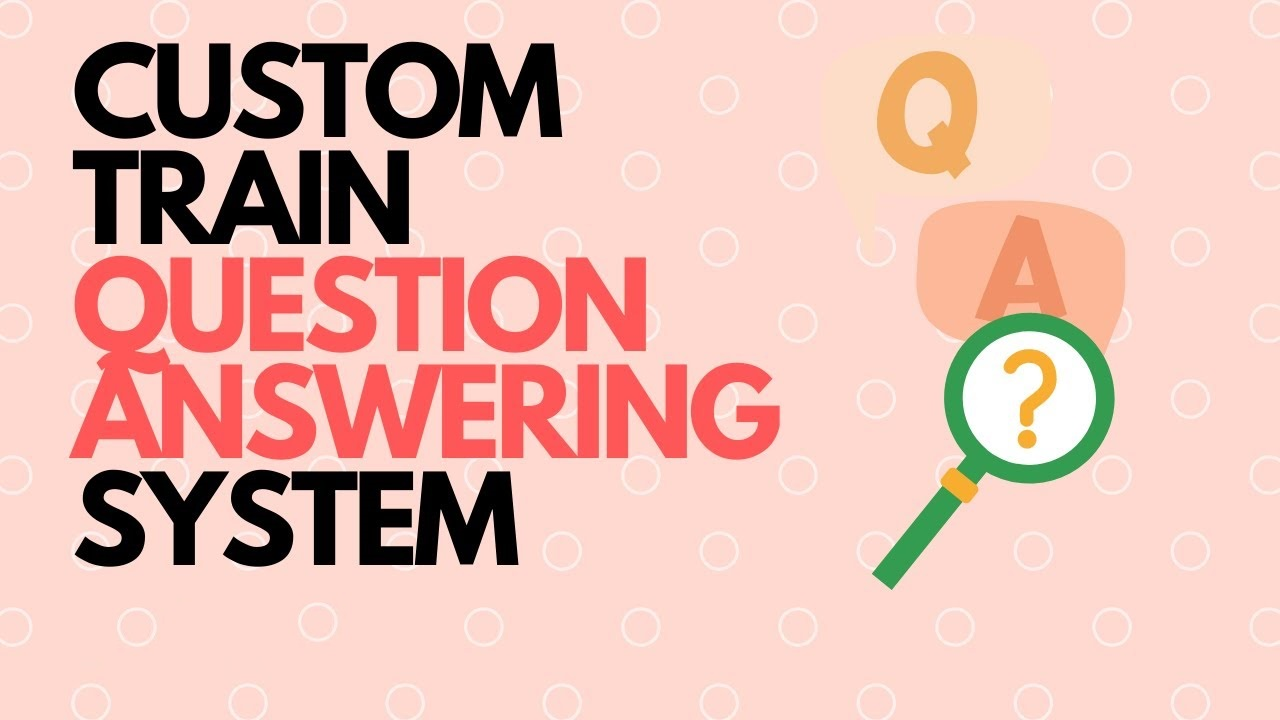